Epoch [1/10], Loss: 0.4515, Train Acc: 85.49%, Val Acc: 97.67%
Epoch [2/10], Loss: 0.0920, Train Acc: 97.62%, Val Acc: 97.87%
Epoch [3/10], Loss: 0.0781, Train Acc: 98.08%, Val Acc: 98.16%
Epoch [4/10], Loss: 0.0672, Train Acc: 98.33%, Val Acc: 98.60%
Epoch [5/10], Loss: 0.0569, Train Acc: 98.59%, Val Acc: 98.60%
Epoch [6/10], Loss: 0.0557, Train Acc: 98.67%, Val Acc: 98.65%
Epoch [7/10], Loss: 0.0472, Train Acc: 98.89%, Val Acc: 98.42%
Epoch [8/10], Loss: 0.0497, Train Acc: 98.86%, Val Acc: 98.31%
Epoch [9/10], Loss: 0.0493, Train Acc: 98.84%, Val Acc: 98.62%
Epoch [10/10], Loss: 0.0350, Train Acc: 99.14%, Val Acc: 98.80%
Accuracy on QMNIST test set: 98.80%


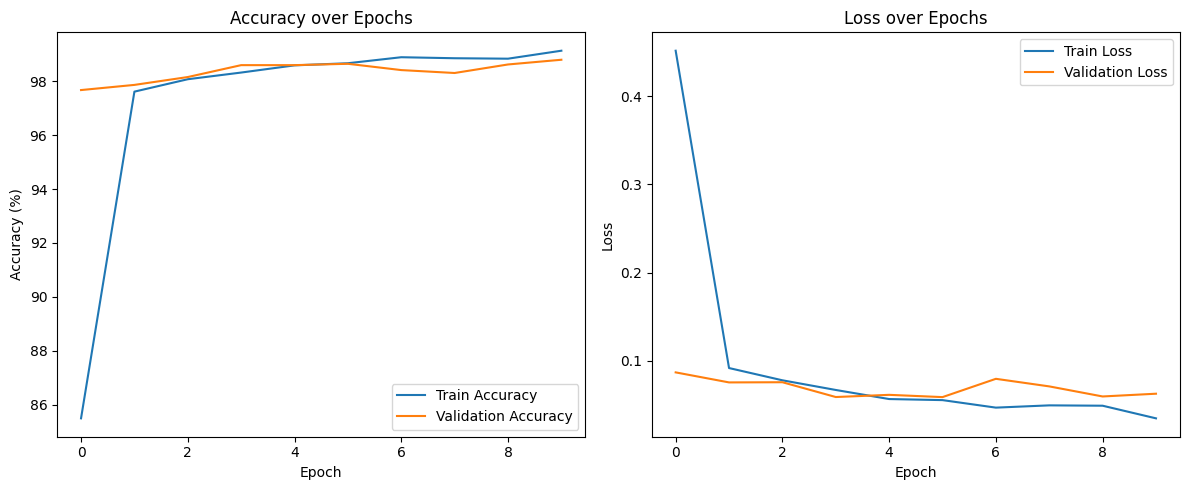

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# QMNIST dataset (32x32 grayscale images)
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.QMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.QMNIST(root='./data', train=False, download=True, transform=transform)

# Splitting the training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# CaffeNet model (adapted for QMNIST and 32x32 input)
class CaffeNet(nn.Module):
    def __init__(self):
        super(CaffeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),  # Updated input size
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10)  # QMNIST has 10 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Custom He + Orthogonal initialization
def custom_init(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(module, nn.Linear):
            nn.init.orthogonal_(module.weight)
        if hasattr(module, 'bias') and module.bias is not None:
            nn.init.constant_(module.bias, 0)

# Model setup
model = CaffeNet().to(device)
custom_init(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Lists to store metrics for plotting
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_acc = 100 * correct_train / total_train
    train_acc_list.append(train_acc)
    train_loss_list.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_acc = 100 * correct_val / total_val
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss / len(val_loader))

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

# Evaluation on test set
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

print(f'Accuracy on QMNIST test set: {100 * correct_test / total_test:.2f}%')

# Plot results
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
